# Using Decision Tree & Naive Bayes to classify Pokemon

## <font color="red">Import libraries</font>

In [1]:
import os
import gc
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pdp
from models import DecisionTree, NaiveBayes
from sklearn.metrics import roc_curve, auc
from multiprocessing.pool import ThreadPool
from utils import plots as pl, samplings as sp, evaluations as ev

%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Huy\Anaconda3\envs\cs235\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


In [2]:
%reload_ext autoreload

In [3]:
# Set packages options
plt.rcParams["figure.figsize"] = (9, 5)
# plt.style.use("seaborn")

## <font color="red">Define constants and functions</font>

In [7]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

DropColumns = ["Pokedex", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

def filterByValue(dataFrame, column, values):
    #return dataFrame[dataFrame[column] == value]
    
    return dataFrame[dataFrame[column].isin(values)]

## <font color="red">Load the data from file</font>

In [3]:
# Load the Pokemon data
filePath = os.path.join(os.getcwd(), "..", "data", "Pokemon_Cleaned.tsv")
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(filePath, header=0, sep='\t', dtype=columnTypes)
data.sample(5)

,Generation,Pokedex,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
63,1.0,49.0,Venomoth,Poison Moth Pokemon,Bug,Poison,Shield Dust,Wonder Skin,Tinted Lens,50.0,...,Bug,None,70.0,65.0,60.0,90.0,75.0,90.0,450,Ordinary
481,4.0,412.0,Burmy Sandy Cloak,Bagworm Pokemon,Bug,None,Shed Skin,Overcoat,None,50.0,...,Bug,None,40.0,29.0,45.0,29.0,45.0,36.0,224,Ordinary
620,5.0,533.0,Gurdurr,Muscular Pokemon,Fighting,None,Sheer Force,Iron Fist,Guts,75.0,...,Human-Like,None,85.0,105.0,85.0,40.0,50.0,40.0,405,Ordinary
815,6.0,699.0,Aurorus,Tundra Pokemon,Rock,Ice,Refrigerate,Snow Warning,None,87.5,...,Monster,None,123.0,77.0,72.0,99.0,92.0,58.0,521,Ordinary
156,6.0,127.0,Mega Pinsir,Stag Beetle Pokemon,Bug,Flying,Aerilate,None,None,50.0,...,Bug,None,65.0,155.0,120.0,65.0,90.0,105.0,600,Ordinary


In [22]:
filterByValue(data, "Pokedex", {6, 9, 97})

,Generation,Pokedex,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
6,6.0,6.0,Mega Charizard Y,Flame Pokemon,Fire,Flying,Drought,None,None,87.5,...,Monster,Dragon,78.0,104.0,78.0,159.0,115.0,100.0,634,Ordinary
7,6.0,6.0,Mega Charizard X,Flame Pokemon,Fire,Dragon,Tough Claws,None,None,87.5,...,Monster,Dragon,78.0,130.0,111.0,130.0,85.0,100.0,634,Ordinary
8,1.0,6.0,Charizard,Flame Pokemon,Fire,Flying,Blaze,Solar Power,None,87.5,...,Monster,Dragon,78.0,84.0,78.0,109.0,85.0,100.0,534,Ordinary
11,1.0,9.0,Blastoise,Shellfish Pokemon,Water,None,Torrent,Rain Dish,None,87.5,...,Monster,Water 1,79.0,83.0,100.0,85.0,105.0,78.0,530,Ordinary
12,6.0,9.0,Mega Blastoise,Shellfish Pokemon,Water,None,Mega Launcher,None,None,87.5,...,Monster,Water 1,79.0,103.0,120.0,135.0,115.0,78.0,630,Ordinary
123,1.0,97.0,Hypno,Hypnosis Pokemon,Psychic,None,Insomnia,Forewarn,Inner Focus,50.0,...,Human-Like,None,85.0,73.0,70.0,73.0,115.0,67.0,483,Ordinary


## <font color="red">Plot graphs to visualize and understand the data</font>

### Group Distribution

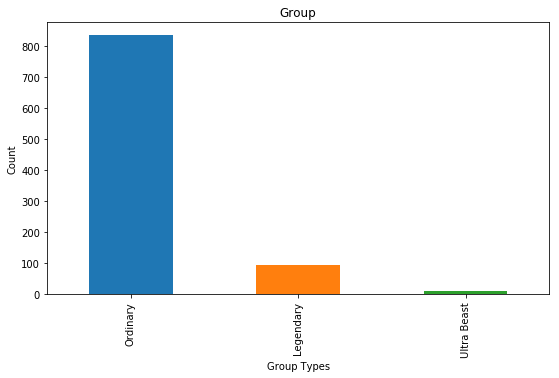

In [6]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = data["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")
plt.show()

### Scatter Plots of Continous Features

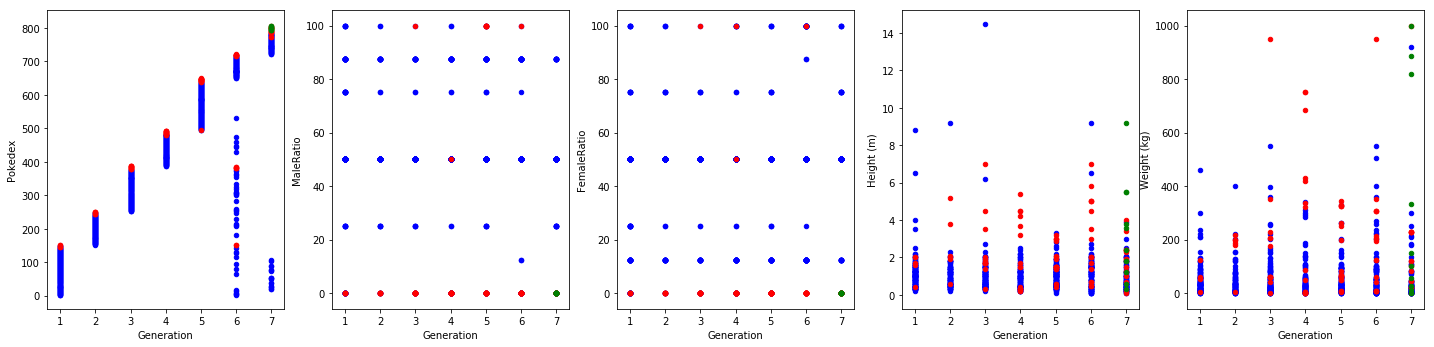

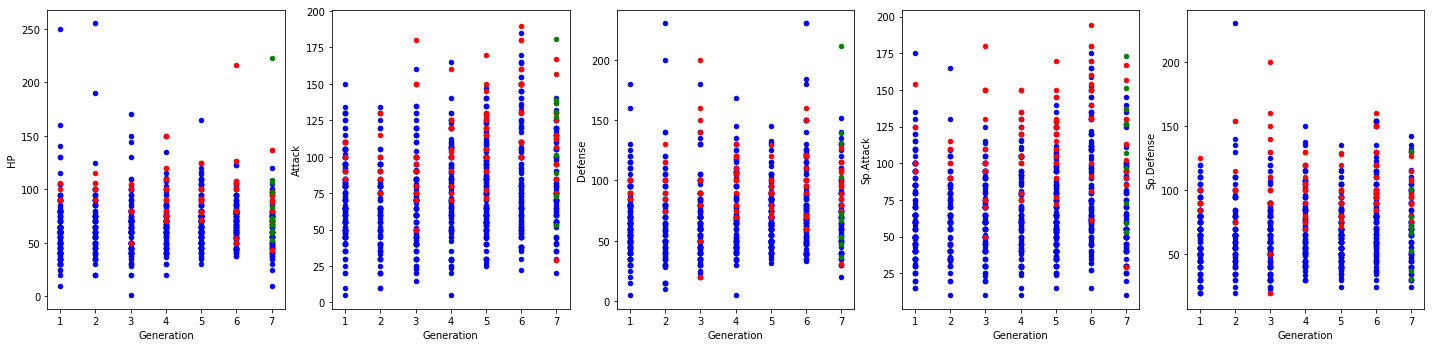

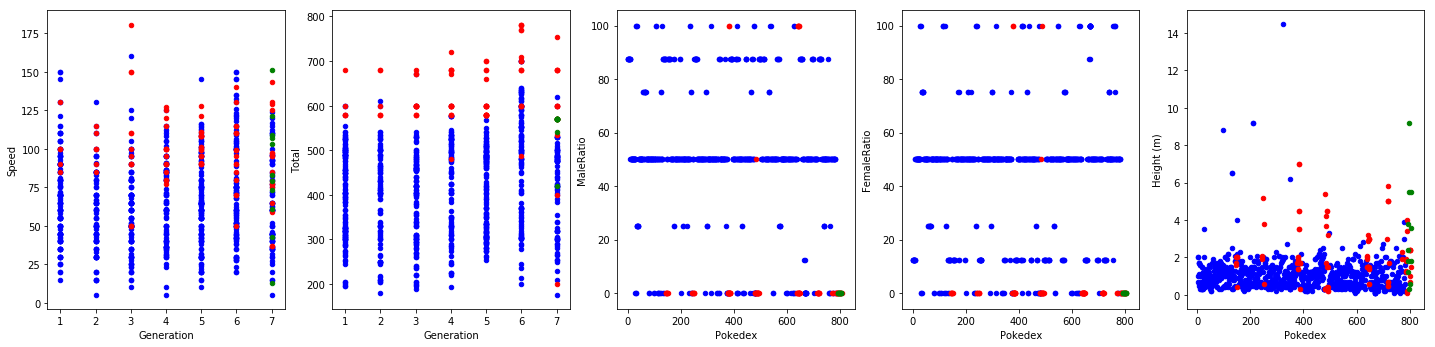

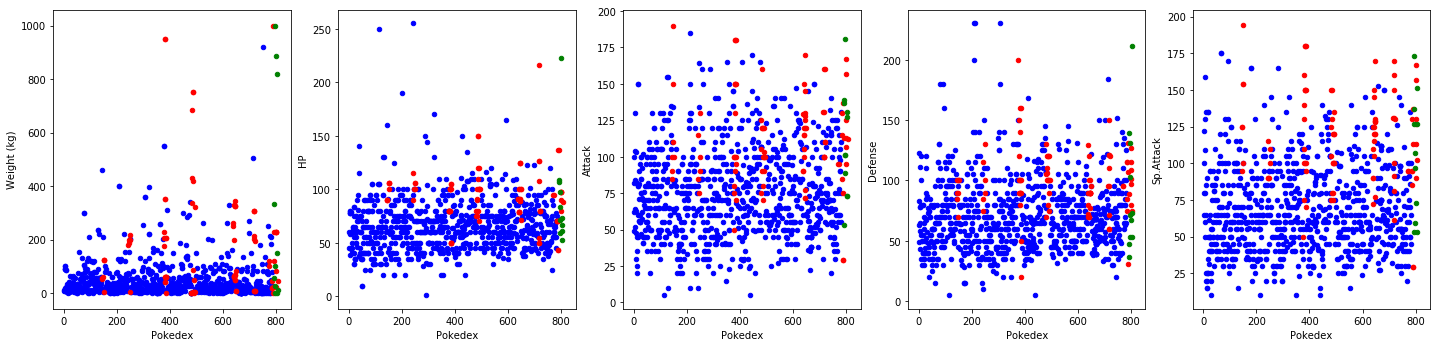

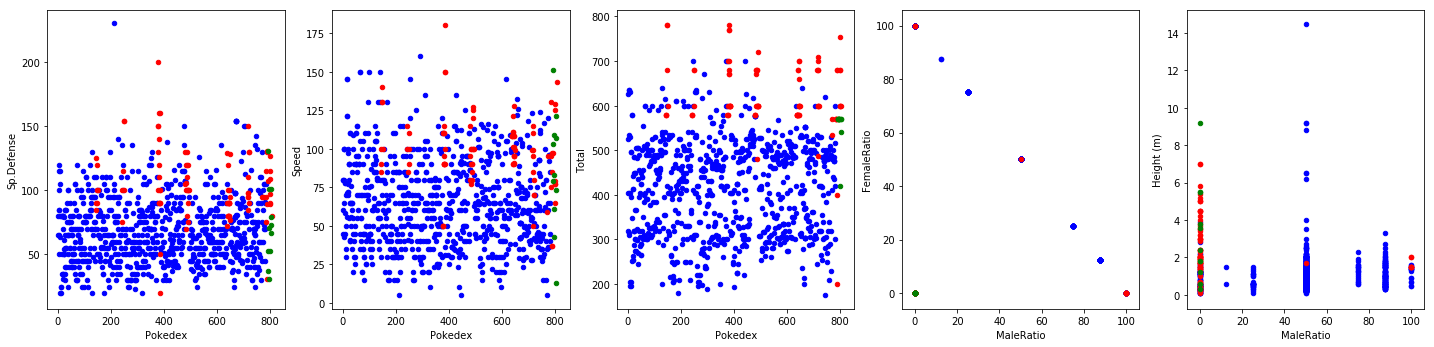

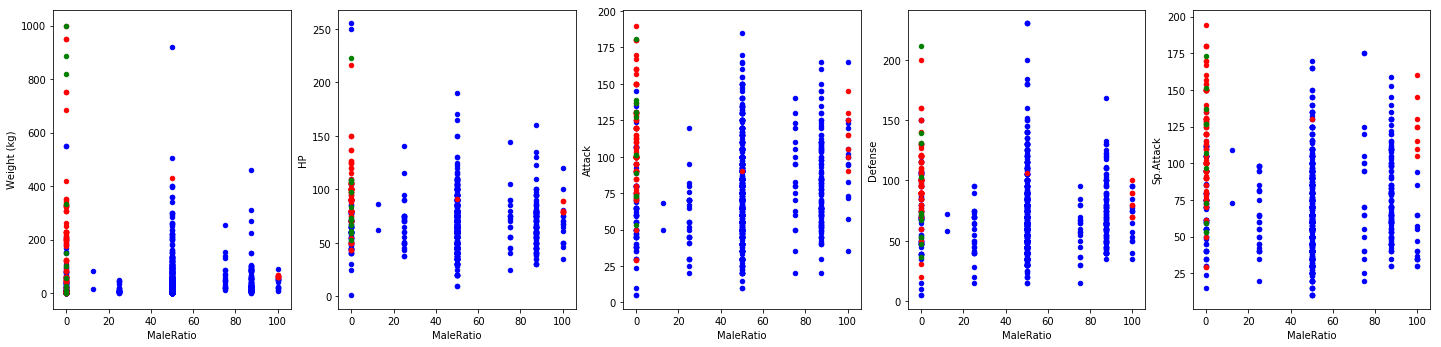

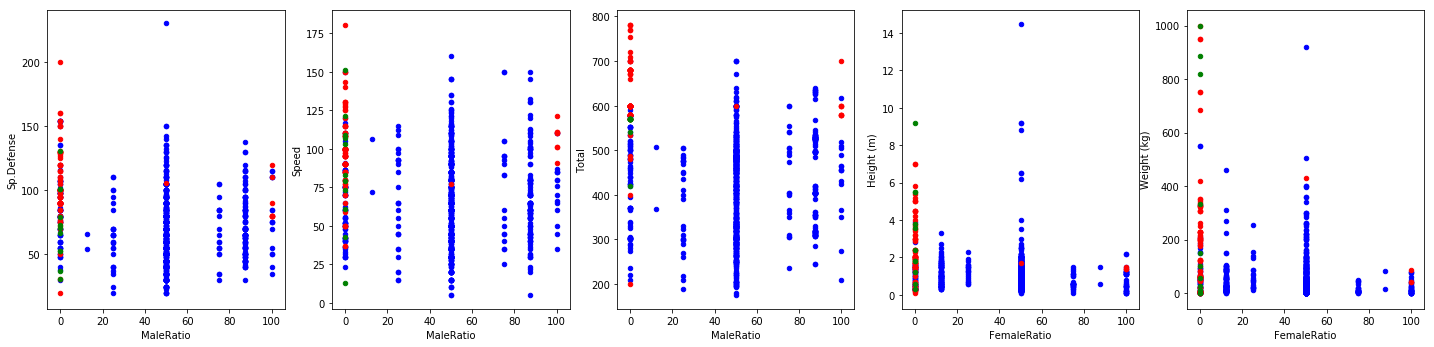

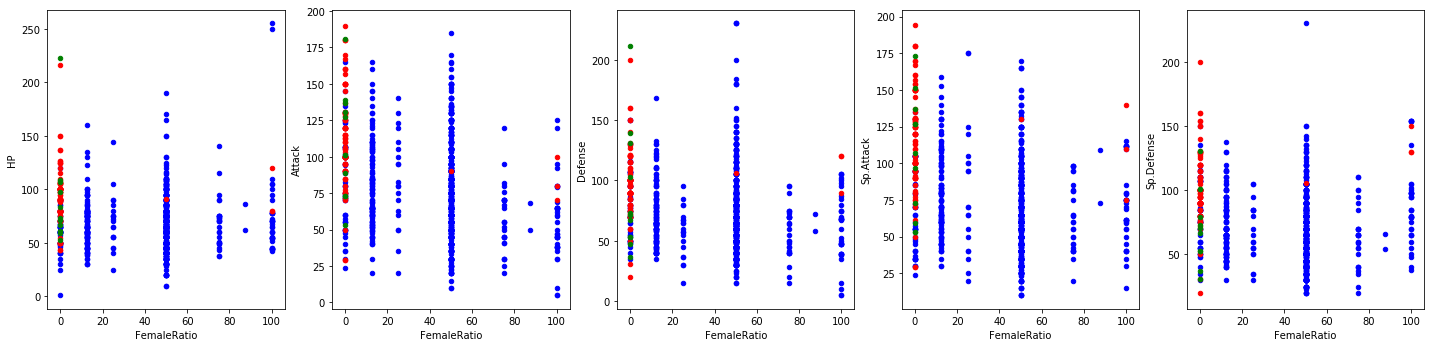

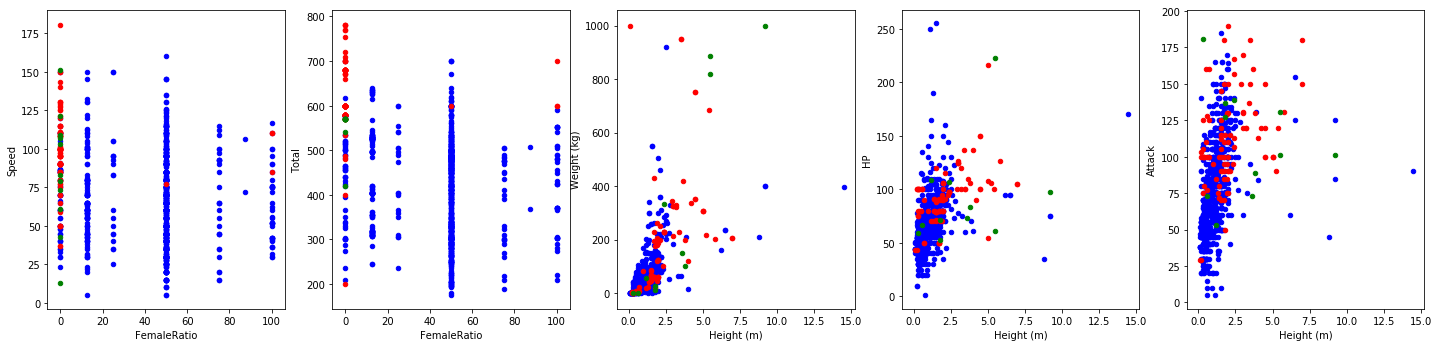

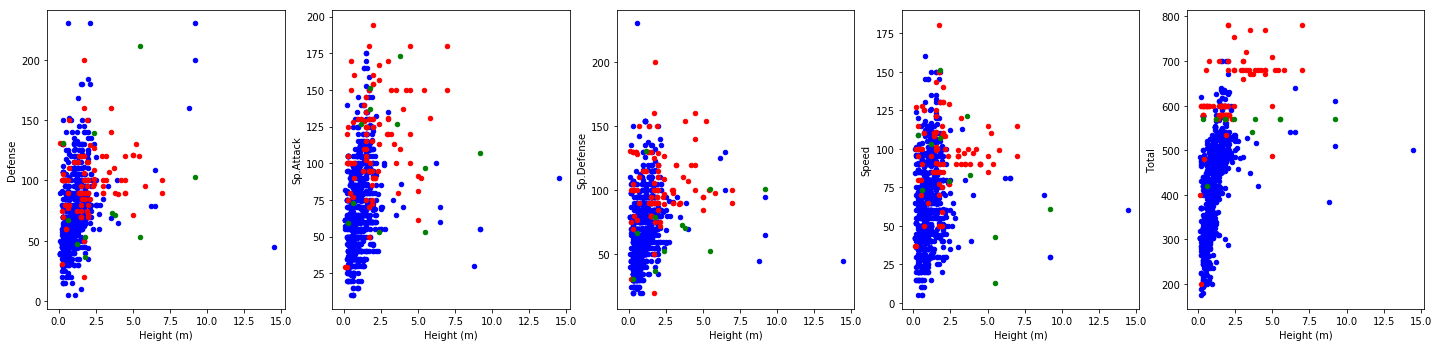

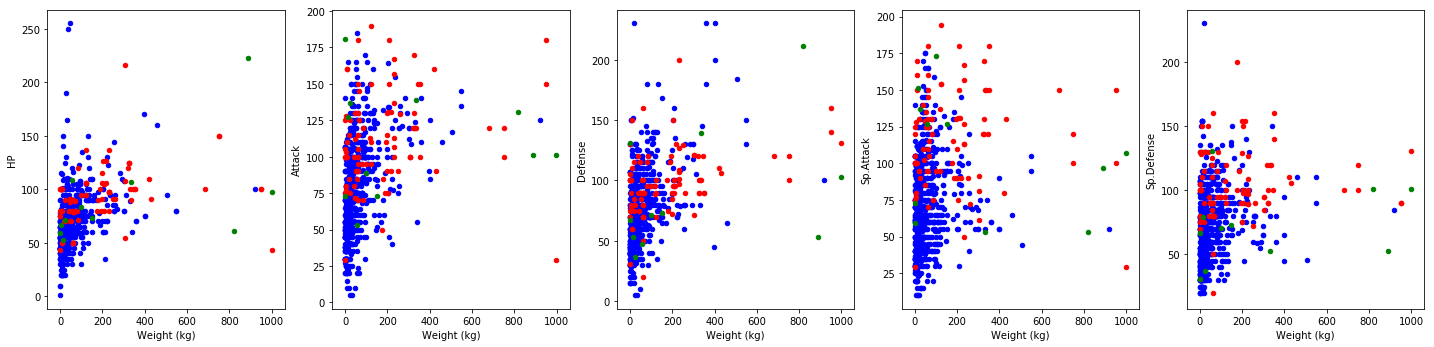

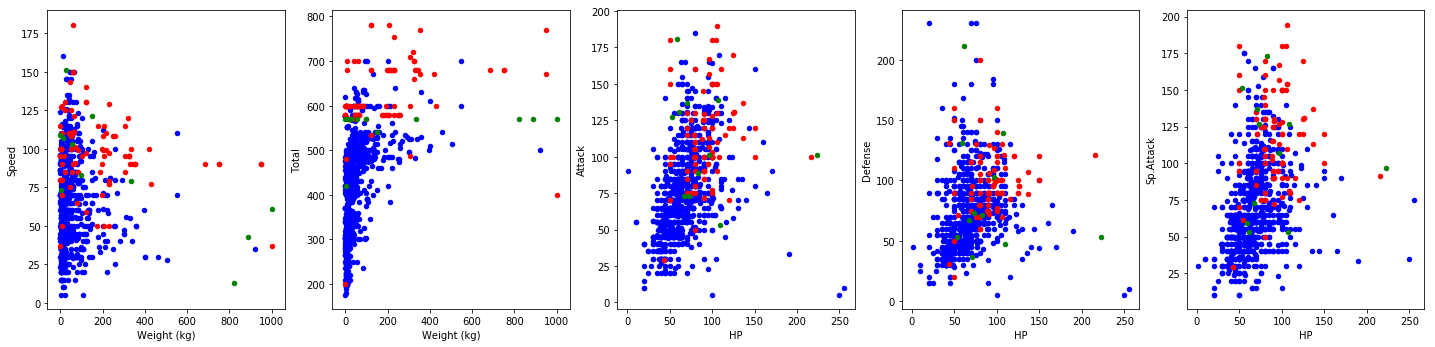

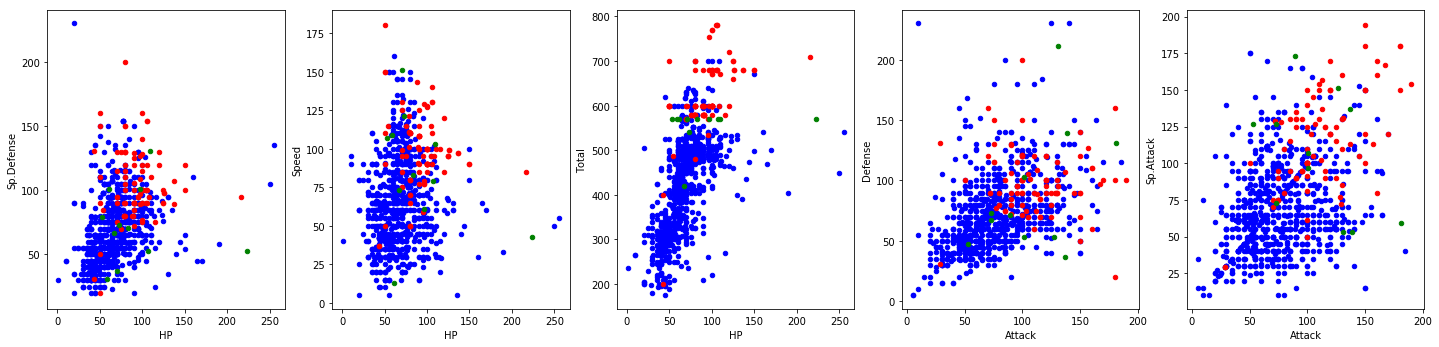

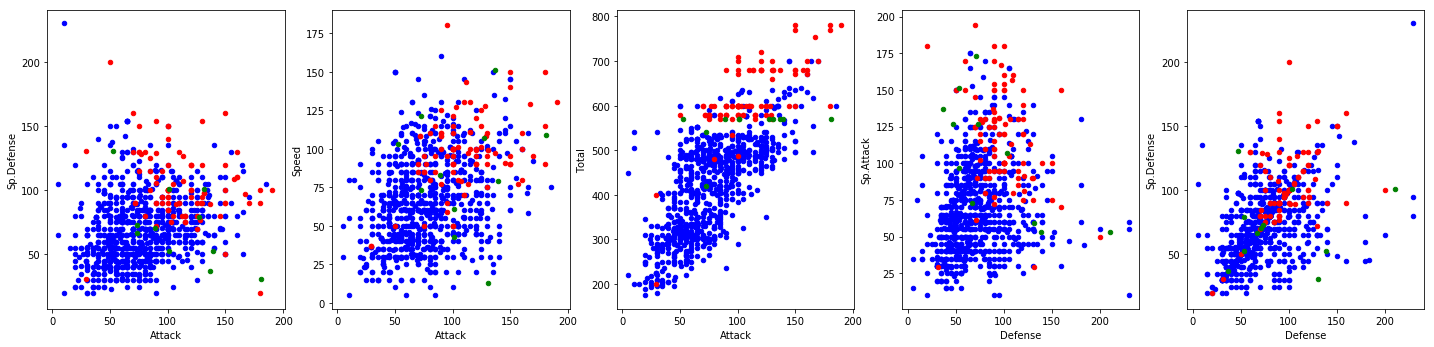

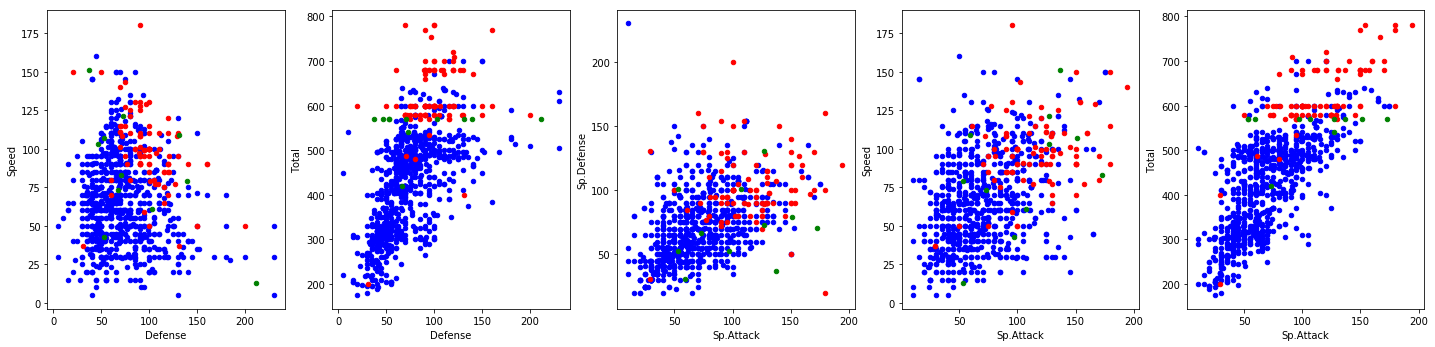

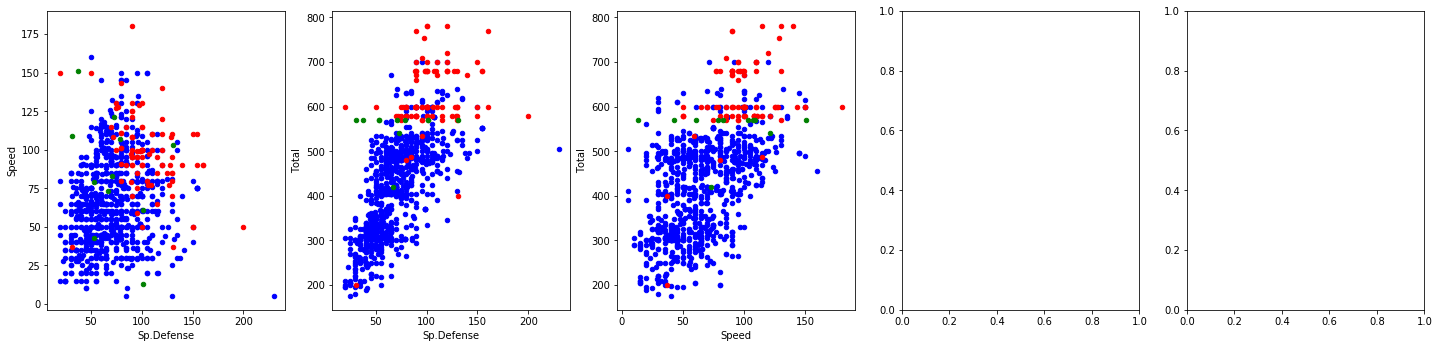

In [7]:
ordi = filterByValue(data, "Group", "Ordinary")
lg = filterByValue(data, "Group", "Legendary")
ub = filterByValue(data, "Group", "Ultra Beast")

continuousFeatures = data.select_dtypes(include=[np.int64, np.float64])#.drop(["Generation", "Pokedex"], axis=1)

# Get each pair of of the continous features but don't include redundant combinations
combinations = []
for x in continuousFeatures:    
    for y in continuousFeatures:
        if (x != y) and (not ((x, y) in combinations or (y, x) in combinations)):
            combinations.append((x, y))

# Plot all the continous features in scatter plots
numPerRow = 5
for i in range(0, len(combinations), numPerRow):
    fig, axes = plt.subplots(1, ncols=numPerRow, figsize=(15, 5.5))
    fig.subplots_adjust(right=1.4)
    for j in range(numPerRow):
        # Break if there is no more combination to plot
        if (i + j >= len(combinations)): break
        x, y = combinations[i+j]
        axe = ordi.plot(x, y, kind="scatter", c="b", ax=axes[j])
        lg.plot(x, y, kind="scatter", c="r", ax=axe)
        ub.plot(x, y, kind="scatter", c="g", ax=axe)
    plt.show()

### Histograms of Continuous Features

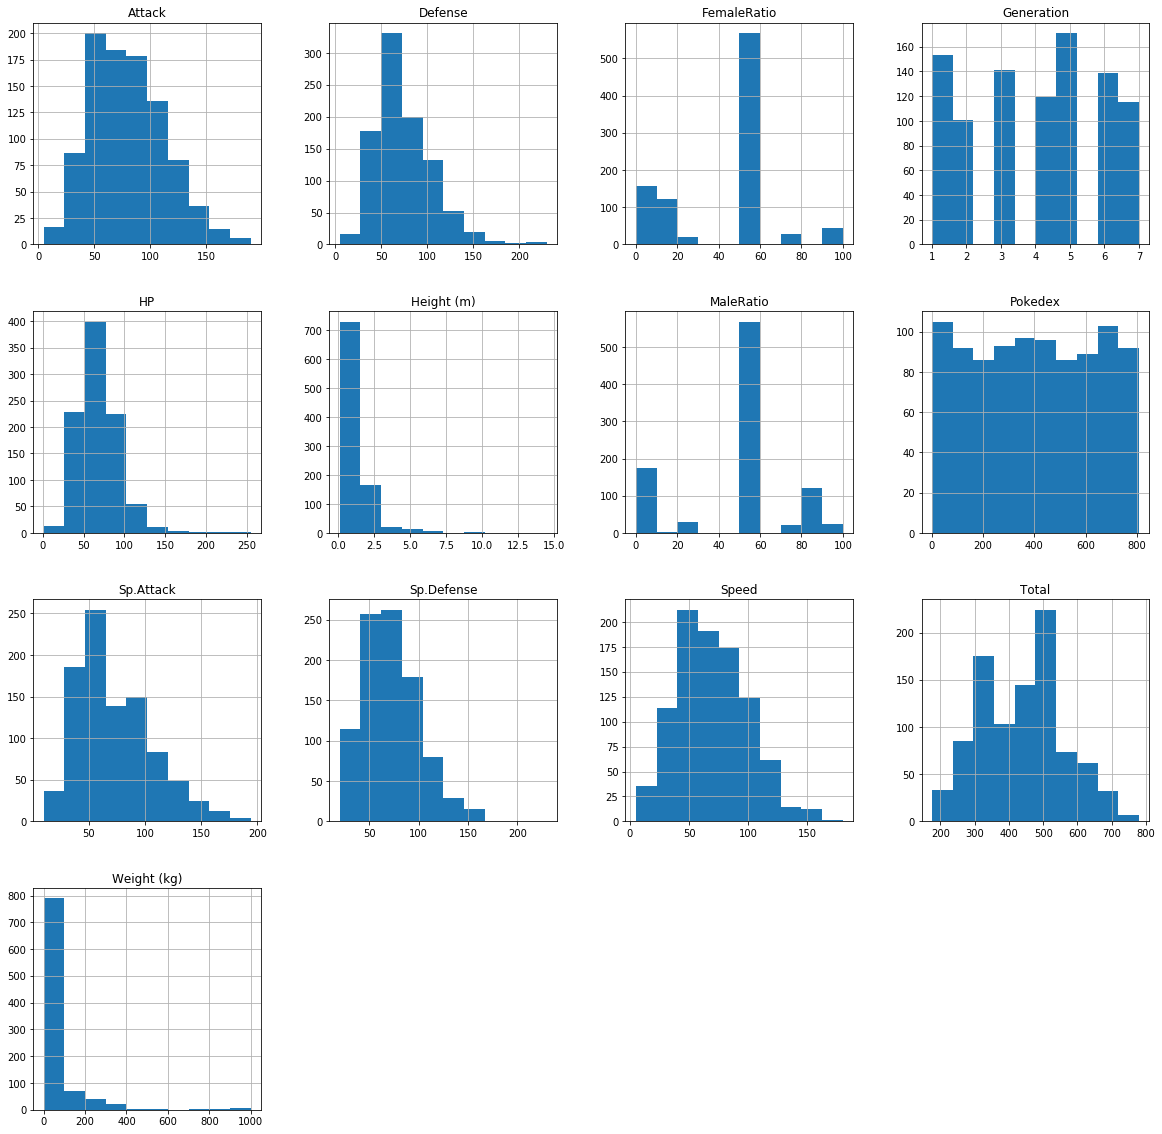

In [8]:
data.hist(figsize=(20,20))
plt.show()

We can see that features with uniform distribution may not contribute much to Decision Tree model because the model will be biased toward to those features since there is more entropy within those features.

### Box Plot of Total & Group

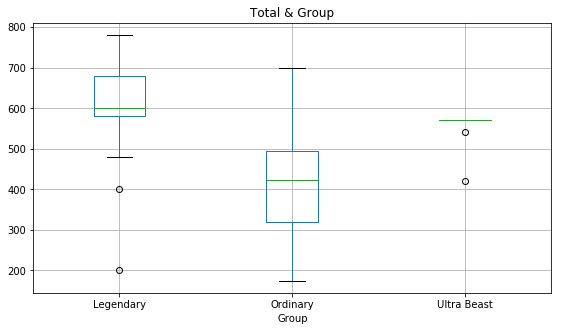

In [9]:
data.boxplot("Total", "Group")
plt.title("Total & Group")
plt.suptitle("")
plt.show()

<p> According to the boxplot above, we can see that despite having a small quanity in size, <b>Legendary Pokemon</b> has the highest <b>Total</b> stats compared to the other 2 groups.</p>

In [6]:
# # Get data profile. Only use continuous features
profileFilePath = os.path.join(os.getcwd(), "..", "data", "Profile.html")
profile = pdp.ProfileReport(data.select_dtypes(include=[np.int64, np.float64]))
profile.to_file(profileFilePath)

## <font color="red"/>Training & Test Data</font>

In [4]:
Target = "Group"
Labels = data[Target].unique()
LabelColors = {"Ordinary": "b", "Legendary": "r", "Ultra Beast": "g"}

ReducedData = data.drop(DropColumns, axis=1)

In [21]:
## Run this block of code to save the training data points to a file after generating the train/test set once.
## For consistent runs without using random samples when notebook is shutdown.

Training, Test = sp.splitData(Target, ReducedData, 0.70)
## Create if it doesn't exist
# if (not os.path.isfile("training.txt")):
#     with open("training.txt", "w") as file:
#         for i in Training.index:
#             file.write(str(i) + " ")

# Load the data points to Training and Test variables
# Training = None
# Test = None
# sampleFilePath = os.path.join("..", "data", "sample.txt")
# with open(sampleFilePath, "r") as file:
#     indeces = list(map(lambda x: int(x), file.readline().strip().split(" ")))
#     Test = ReducedData.drop(index=indeces)
#     Training = ReducedData.drop(index=Test.index)

In [22]:
print("**** Training ****")
print(Training[Target].value_counts(), "\n")
print("**** Test ****")
print(Test[Target].value_counts())

**** Training ****
Ordinary       582
Legendary       68
Ultra Beast      7
Name: Group, dtype: int64 

**** Test ****
Ordinary       252
Legendary       26
Ultra Beast      4
Name: Group, dtype: int64


## <font color="red">Decision Tree</font>

In [28]:
# Use Decision Tree to train on the training set and predict on the test set
dtree = DecisionTree(Target, maxDepth=3)
dtree.train(Training)
dtPred = dtree.classify(Test.drop([Target], axis=1))

Function "train" took 7.18 seconds to complete


In [29]:
dtMatrix = ev.buildConfusionMatrix(dtPred["Prediction"], Test[Target], Labels)
dtPrecisions, dtRecalls = ev.getPrecisionsAndRecalls(dtMatrix, Labels)
dtFScores = ev.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ev.computeError(dtPred["Prediction"], Test["Group"]) * 100)

'Error 7.45%'

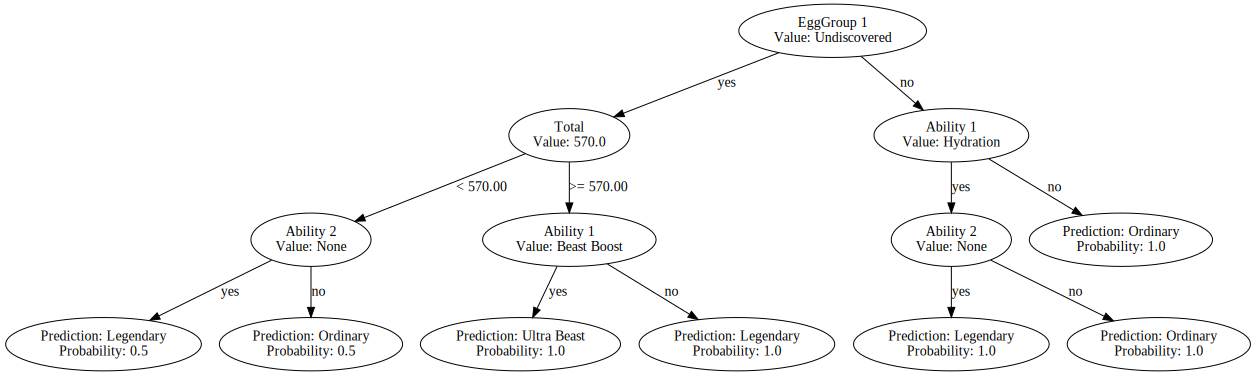

In [30]:
dtree.generateGraph()

## Compare k-tile vs. mean

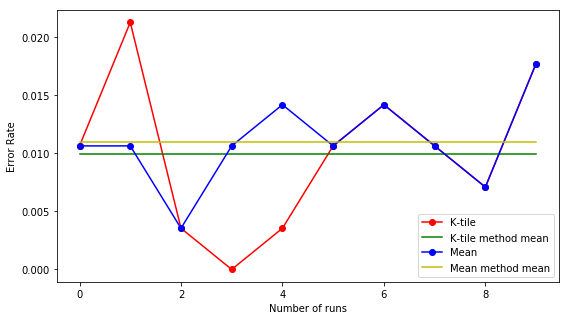

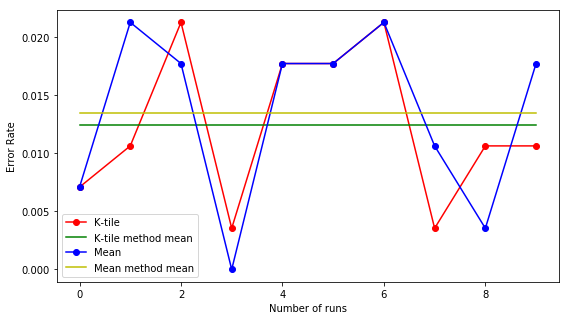

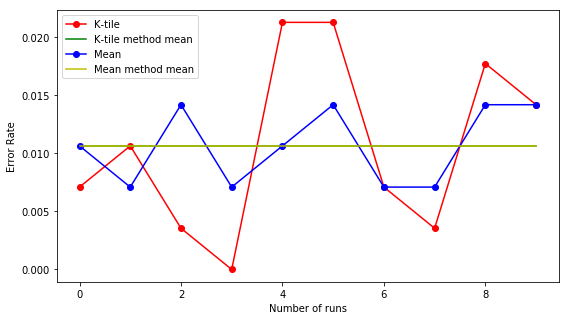

In [15]:
e1 = []
e2 = []
d1 = DecisionTree(Target, continuousSplitmethod="k-tile", maxDepth=4)
d2 = DecisionTree(Target, continuousSplitmethod="mean", maxDepth=4)
runCount = 10

# Plot 3 results
for i in range(3):
    # For each plot, gather the error rate from 10 runs
    for j in range(runCount):
        training, test = sp.splitData(Target, ReducedData, 0.70)
        d1.train(training, quiet=True)
        d2.train(training, quiet=True)
        
        p1 = d1.classify(test.drop([Target], axis=1))
        p2 = d2.classify(test.drop([Target], axis=1))
        e1.append(ev.computeError(p1["Prediction"], test["Group"]))
        e2.append(ev.computeError(p2["Prediction"], test["Group"]))
    
    # Plot each result
    x = [i for i in range(runCount)]
    plt.plot(x, e1, 'ro-', label="K-tile")
    plt.plot(x, [sum(e1)/len(e1) for i in range(runCount)], 'g-', label="K-tile method mean")
    plt.plot(x, e2, 'bo-', label="Mean")
    plt.plot(x, [sum(e2)/len(e2) for i in range(runCount)], 'y-', label="Mean method mean")
    plt.xlabel("Number of runs")
    plt.ylabel("Error Rate")
    plt.legend(loc="best")
    del e1[:]
    del e2[:]
    plt.show()

### Decision Tree Confusion Matrix

In [9]:
dtMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,0,29,0,29
Actual Ordinary,5,246,0,251
Actual Ultra Beast,0,1,1,2
Total,5,276,1,282


In [10]:
dtPrecisions

{'Legendary': 0.0, 'Ordinary': 0.8913043478260869, 'Ultra Beast': 1.0}

In [11]:
dtRecalls

{'Legendary': 0.0, 'Ordinary': 0.9800796812749004, 'Ultra Beast': 0.5}

In [12]:
print("Average across all labels:", dtFScores[0])
dtFScores[1]

Average across all labels: 0.5334176681425258


{'Legendary': 0,
 'Ordinary': 0.9335863377609108,
 'Ultra Beast': 0.6666666666666666}

### Decision Tree ROC Curve

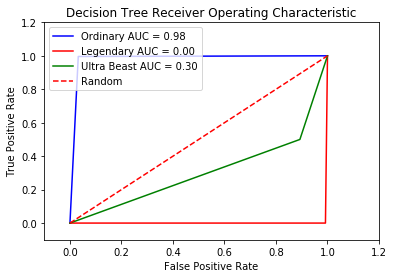

In [13]:
dtRoc = pl.plotRocCurve(Test[Target], dtPred["Probability"], LabelColors, "Decision Tree")

### Decision Tree Depth

In [21]:
treeDepths = [i for i in range(10)]
depthErrors = []
learner = DecisionTree(Target)
for depth in treeDepths:
    learner.maxDepth = depth
    learner.train(Training, quiet=True)
    pred = learner.classify(Test.drop([Target], axis=1))
    err = ev.computeError(pred["Prediction"], Test[Target])
    depthErrors.append(err)

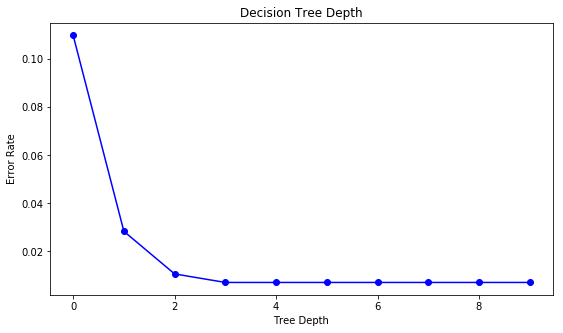

In [22]:
plt.plot(treeDepths, depthErrors, 'bo-')
plt.title("Decision Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.show()

### Decision Tree Precision-Recall Curve

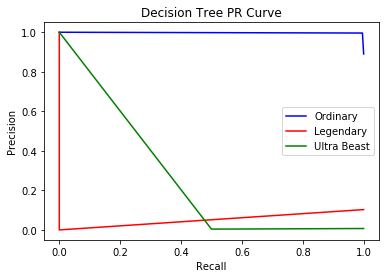

In [14]:
p, r = pl.precisionRecallCurve(Test[Target], dtPred["Probability"])
dtPrCurve = pl.plotPrecisionRecallCurve(p, r, LabelColors, "Decision Tree PR Curve")

### Decision Tree K Fold Cross Validation

In [24]:
dtKErrors = sp.kFoldCrossValidationResult(10, Target, Training, dtree)

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k exceeds the label with the smallest number of data points. k=10, smallest # of data points of a label=9. Return early...


In [62]:
# Compute the and means, variances, and standard deviations of the k fold cross validation result
means = [sum(e) / len(e) for e in dtKErrors]
stds =  []
variances = []

for e, m in zip(dtKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

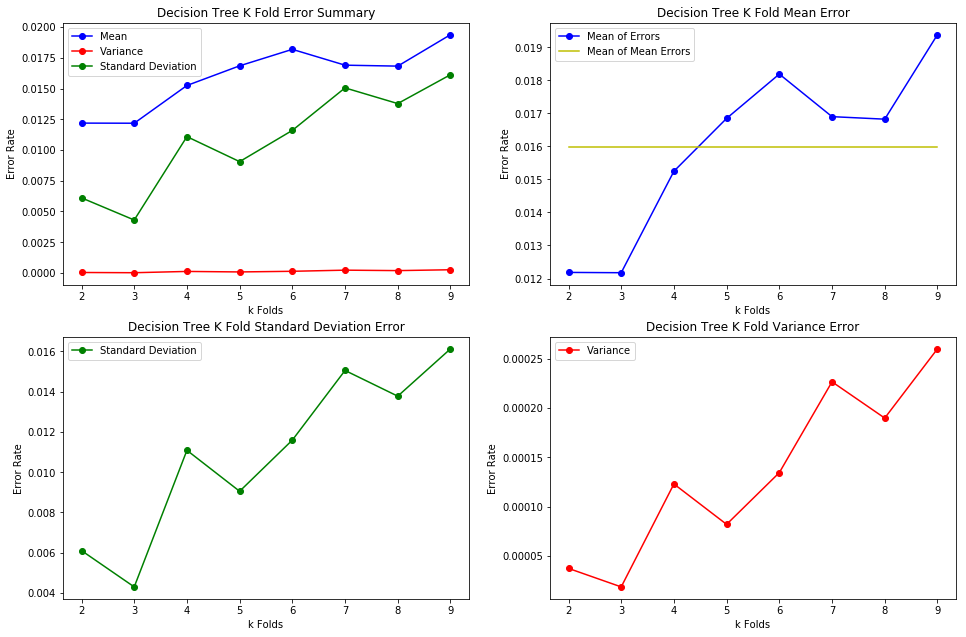

In [69]:
# Plot the error rates represented by the mean, variance, and standard deviation
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Decision Tree K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean of Errors")
axes[0, 1].plot([i for i in kRange], [sum(means)/len(means) for i in kRange], "y-", label="Mean of Mean Errors")
axes[0, 1].set_title("Decision Tree K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Decision Tree K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Decision Tree K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## <font color="red">Naive Bayes</font>

In [14]:
# Use Naive Bayes to train on the training set and predict on the test data set
nBayes = NaiveBayes(Target, Labels)
nBayes.train(Training)
nbPred = nBayes.classify(Test.drop([Target], axis=1))

Function "train" took 3.83 seconds to complete
Function "classify" took 9.28 seconds to complete


In [15]:
nbMatrix = ev.buildConfusionMatrix(nbPred["Prediction"], Test[Target], Labels)
nbPrecisions, nbRecalls = ev.getPrecisionsAndRecalls(nbMatrix, Labels)
nbFScores = ev.computeFScores(nbPrecisions, nbRecalls)
"Error: {0:.2f}%".format(ev.computeError(nbPred["Prediction"], Test["Group"]) * 100)

'Error: 7.09%'

### Naive Bayes Confustion Matrix

In [29]:
nbMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,23,1,5,29
Actual Ordinary,2,238,11,251
Actual Ultra Beast,0,1,1,2
Total,25,240,17,282


In [30]:
nbPrecisions

{'Legendary': 0.92,
 'Ordinary': 0.9916666666666667,
 'Ultra Beast': 0.058823529411764705}

In [31]:
nbRecalls

{'Legendary': 0.7931034482758621,
 'Ordinary': 0.9482071713147411,
 'Ultra Beast': 0.5}

In [32]:
print("Average across all labels:", nbFScores[0])
nbFScores[1]

Average across all labels: 0.6421883705265276


{'Legendary': 0.851851851851852,
 'Ordinary': 0.969450101832994,
 'Ultra Beast': 0.10526315789473684}

### Naive Bayes ROC Curve

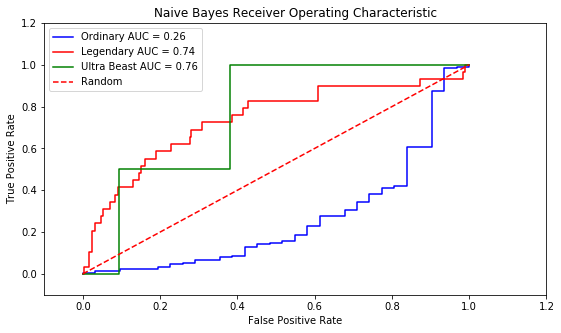

In [16]:
nbRoc = pl.plotRocCurve(Test[Target], nbPred["Probability"], LabelColors, "Naive Bayes")

### Naive Bayes Precision-Recall Curve

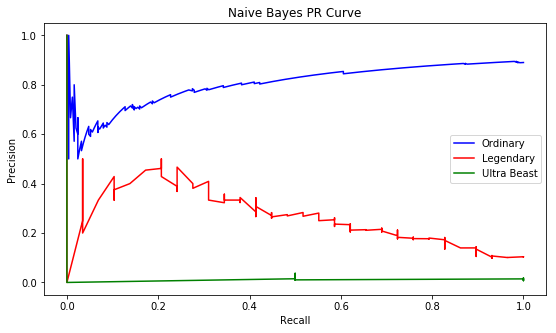

In [17]:
p, r = pl.precisionRecallCurve(Test[Target], nbPred["Probability"])
nbPrCurve = pl.plotPrecisionRecallCurve(p, r, LabelColors, "Naive Bayes PR Curve")

### Perform K Fold Cross Validations

In [35]:
nbKErrors = ev.kFoldCrossValidationResult(10, Target, Training, nBayes)

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k exceeds the label with the smallest number of data points. k=10, smallest # of data points of a label=9. Return early...


In [70]:
# Compute the and means, variances, and standard deviations of the k fold cross validation result
means = [sum(e) / len(e) for e in nbKErrors]
stds =  []
variances = []

for e, m in zip(nbKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

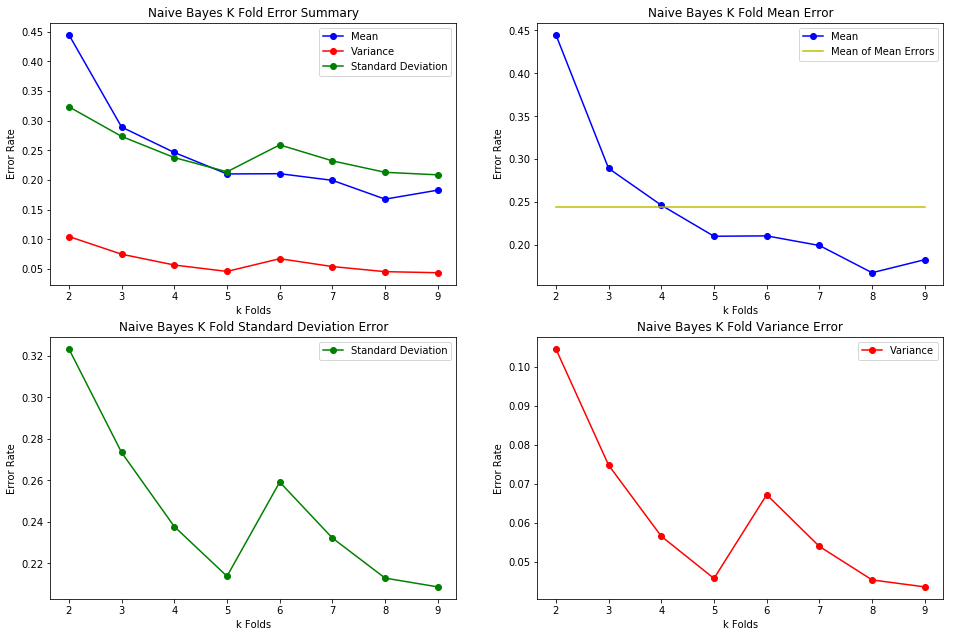

In [71]:
# Plot the error rates represented by the mean, variance, and standard deviation
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Naive Bayes K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 1].plot([i for i in kRange], [sum(means)/len(means) for i in kRange], "y-", label="Mean of Mean Errors")
axes[0, 1].set_title("Naive Bayes K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Naive Bayes K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Naive Bayes K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## <font color="red">Estimating Confidence Interval</font>

In [38]:
dtModel = DecisionTree(Target, maxDepth=3)
nbModel = NaiveBayes(Target, Labels)
pool = ThreadPool(processes=2)

In [39]:
k = 10
training, test = ut.splitData(Target, ReducedData, 0.70)
kTrainings, kTests = ut.kFoldCrossValidation(10, training)

In [40]:
dtErrors = []
nbErrors = []

for kTraining, kTest in zip(kTrainings, kTests):
    kTestTarget = kTest[Target]
    kTest = kTest.drop([Target], axis=1)
    
    t1 = pool.apply_async(dtModel.train, (kTraining,), dict(quiet=True))
    t2 = pool.apply_async(nbModel.train, (kTraining,), dict(quiet=True))

    t1.wait()
    t2.wait()
    
    t3 = pool.apply_async(dtModel.classify, (kTest,), dict(quiet=True))
    t4 = pool.apply_async(nbModel.classify, (kTest,), dict(quiet=True))
    
    dtPred = t3.get()
    nbPred = t4.get()
    
    dtErrors.append(ev.computeError(dtPred["Prediction"], kTestTarget))
    nbErrors.append(ev.computeError(nbPred["Prediction"], kTestTarget))  

In [86]:
tValue = abs(ev.tTest(dtErrors, nbErrors, k))
"t value is {0}".format(tValue)

't value is 2.3195601051567722'

Use this link https://surfstat.anu.edu.au/surfstat-home/tables/t.php to check the p-value. Degree of freedom is k-1 and t value is the value above.

## <font color="red">Average of 10 runs</font>

In [ ]:
k = 10
dt_errors = []
dt_aucs = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
dt_precisions = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
dt_recalls = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
dt_fscores = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}

nb_errors = []
nb_aucs = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
nb_precisions = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
nb_recalls = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}
nb_fscores = {"Ordinary": [], "Legendary": [], "Ultra Beast": []}

for i in range(k):
    print("k =", i+1)
    training, test = ev.splitData(Target, ReducedData, 0.70)
    # Naive Bayes
    nBayes.train(training, quiet=True)
    nbPred = nBayes.classify(test.drop([Target], axis=1), quiet=True)
    
    nbMatrix = ev.buildConfusionMatrix(nbPred["Prediction"], test[Target], Labels)
    nbPrecisions, nbRecalls = ev.getPrecisionsAndRecalls(nbMatrix, Labels)
    nbFScores = ev.computeFScores(nbPrecisions, nbRecalls)[1]
    nbError = ev.computeError(nbPred["Prediction"], test[Target])
    
    nb_errors.append(nbError)
    
    for label in Labels:
        nb_precisions[label].append(nbPrecisions[label])
        nb_recalls[label].append(nbRecalls[label])
        nb_fscores[label].append(nbFScores[label])
        
        fpr, tpr, rocThresholds = roc_curve(y_true=test[Target], y_score=[v[1] for v in nbPred.values], pos_label=label)
        rocAuc = auc(fpr, tpr)
        nb_aucs[label].append(rocAuc)
          
    # Decision Tree
    dtree.train(training, quiet=True)
    dtPred = dtree.classify(test.drop([Target], axis=1))
    
    dtMatrix = ev.buildConfusionMatrix(dtPred["Prediction"], test[Target], Labels)
    dtPrecisions, dtRecalls = ev.getPrecisionsAndRecalls(dtMatrix, Labels)
    dtFScores = ev.computeFScores(dtPrecisions, dtRecalls)[1]
    dtError = ev.computeError(dtPred["Prediction"], test[Target])
    
    dt_errors.append(dtError)
    
    for label in Labels:
        dt_precisions[label].append(dtPrecisions[label])
        dt_recalls[label].append(dtRecalls[label])
        dt_fscores[label].append(dtFScores[label])
        
        fpr, tpr, rocThresholds = roc_curve(y_true=test[Target], y_score=[v[1] for v in dtPred.values], pos_label=label)
        rocAuc = auc(fpr, tpr)
        dt_aucs[label].append(rocAuc)

In [ ]:
print(sum(dt_errors)/len(dt_errors)*100)
for label in Labels:
    print(label)
    print(" auc", sum(dt_aucs[label]) / len(dt_aucs[label]))
    print(" precisions", sum(dt_precisions[label]) / len(dt_precisions[label]))
    print(" recalls", sum(dt_recalls[label]) / len(dt_recalls[label]))
    print(" fscores", sum(dt_fscores[label]) / len(dt_fscores[label]))
    print()

In [ ]:
gc.collect()